# Making Transformers Efficient in Production

## Intent Detection as a Case Study

Let’s suppose that we’re trying to build a text-based assistant for our company’s call center so that customers can request their account balance or make bookings without needing to speak with a human agent.

In order to understand the goals of a customer, our assistant will need to be able to classify a wide variety of natural language text into a set of predefined actions or intents.

As a baseline, we’ve fine-tuned a BERT-base model that achieves around 94% accuracy on the CLINC150 dataset. This dataset includes 22,500 in-scope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 out-of-scope queries that belong to an oos intent class. 

In practice we would also gather our own in-house dataset, but using public data is a great way to iterate quickly and generate preliminary results.

In [1]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

2024-06-28 13:40:24.092177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132:

Let’s now look at creating a benchmark that we can use to evaluate the performance of our baseline model.

## Creating a Performance Benchmark

In [2]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [3]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [4]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [5]:
pipe(sample["text"])[0]["label"]

'transfer'

In [6]:
import torch
import numpy as np
from pathlib import Path
from time import perf_counter

from datasets import load_metric

accuracy_score = load_metric("accuracy")

/var/folders/n0/fjbb__hs3pg2sbx4w8k8h3180000gq/T/ipykernel_83957/3996629210.py:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")
/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [7]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline 
        self.dataset = dataset
        self.optim_type = optim_type
    
    def compute_accuracy(self):
        preds, labels = [], []
        
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"]
            label = example["intent"]
            preds.append(intents.str2int(pred))
            labels.append(label)
            
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy
    
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        
        # Delete temporary file
        tmp_path.unlink()
        
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}
    
    def time_pipeline(self, query="What is the pin number for my account?"):
        latencies = []
        
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
            
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [8]:
clinc["test"]

Dataset({
    features: ['text', 'intent'],
    num_rows: 5500
})

In [9]:
pb = PerformanceBenchmark(pipe, clinc["test"])

perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 26.96 +\- 1.88
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Knowledge Distillation for Fine-Tuning

### Knowledge Distillation for Pre-Training

### Creating a Knowledge Distillation Trainer

In [10]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [11]:
import torch.nn as nn 
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
        
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        
        # Extract logits from teacher:
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
            
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1)
            )
        
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss
        

### Choosing a Good Student Initialization

In [12]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

Here we’ve removed the text column since we no longer need it, and we’ve also renamed the intent column to labels so it can be automatically detected by the trainer.

In [14]:
clinc_enc

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5500
    })
})

In [15]:
# from huggingface_hub import notebook_login

# notebook_login()

In [16]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [17]:
batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=False)

In [18]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = intents.num_classes
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

student_config = AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id)

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [19]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt, num_labels=num_labels).to(device)
distilbert_trainer = DistillationTrainer(model_init=student_init,
                                         teacher_model=teacher_model, args=student_training_args,
                                         train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
                                         compute_metrics=compute_metrics, tokenizer=student_tokenizer)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# distilbert_trainer.train()

In [21]:
# distilbert_trainer.push_to_hub("Training completed!")

With our model now safely stored on the Hub, we can immediately use it in a pipeline for our performance benchmark:

In [22]:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"

pipe = pipeline("text-classification", model=finetuned_ckpt)

In [23]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)

perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 14.39 +\- 0.77
Accuracy on test set - 0.858


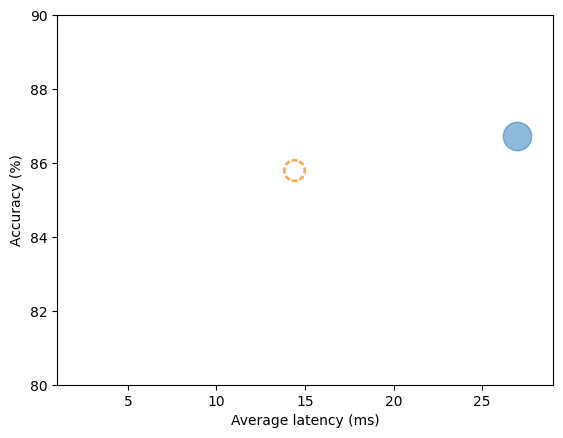

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    
    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    # legend = plt.legend(bbox_to_anchor=(1,1))
    # for handle in legend.legendHandles:
    #     handle.set_sizes([20])
        
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylim(80,90)
    
    plt.xlabel("Average latency (ms)")
    plt.ylabel("Accuracy (%)")
    
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

From the plot we can see that by using a smaller model we’ve managed to significantly decrease the average latency. And all this at the price of just over a 1% reduction in accuracy! Let’s see if we can close that last gap by including the distillation loss of the teacher and finding good values for $\alpha$ and T.

### Finding Good Hyperparameters with Optuna

In [25]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
            "alpha": trial.suggest_float("alpha", 0, 1),
            "temperature": trial.suggest_int("temperature", 2, 20)}

In [26]:
# best_run = distilbert_trainer.hyperparameter_search(n_trials=20, direction="maximize", hp_space=hp_space)

In [27]:
# print(best_run)

In [28]:
# for k,v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)

# # Define a new repository to store our distilled model
# distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
# student_training_args.output_dir = distilled_ckpt

# # Create a new Trainer with optimal parameters
# distil_trainer = DistillationTrainer(model_init=student_init, 
#     teacher_model=teacher_model, args=student_training_args, 
#     train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'], 
#     compute_metrics=compute_metrics, tokenizer=student_tokenizer)

# distil_trainer.train();

In [29]:
# distil_trainer.push_to_hub("Training complete")

In [30]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)

optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)

perf_metrics.update(pb.run_benchmark())

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model size (MB) - 255.88
Average latency (ms) - 13.80 +\- 0.76
Accuracy on test set - 0.868


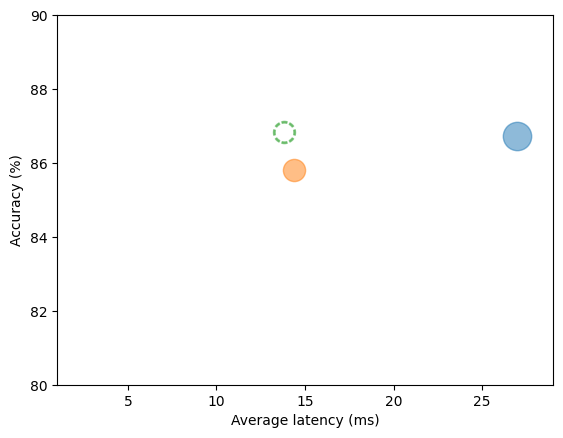

In [31]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster With Quantization

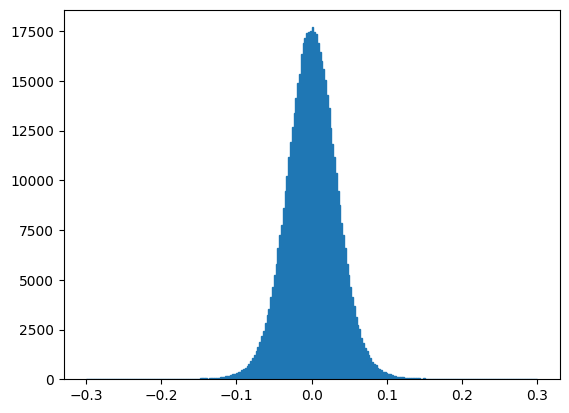

In [32]:
import matplotlib.pyplot as plt
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [33]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [34]:
from torch import quantize_per_tensor
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [35]:
%%timeit
weights @ weights

1.89 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

In [37]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

161 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Compared to our FP32 computation, using the INT8 tensors is almost 100 times faster!

In [38]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/var/folders/n0/fjbb__hs3pg2sbx4w8k8h3180000gq/T/ipykernel_83957/2122423139.py:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [39]:
from torch.quantization import quantize_dynamic
model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Benchmarking Our Quantized Model

In [40]:
pipe = pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 120.07 +\- 22.46
Accuracy on test set - 0.876


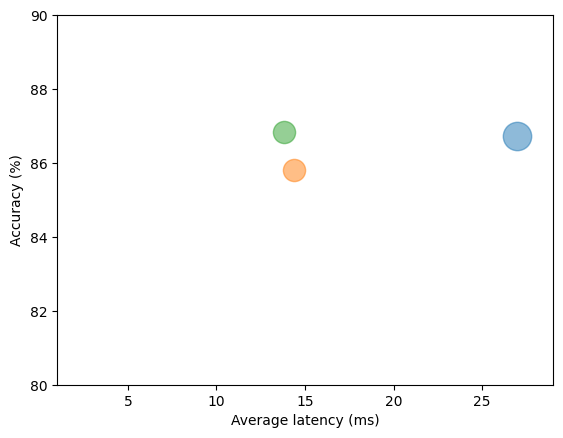

In [41]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONNX Runtime

to convert our distilled model into the ONNX format. The Transformers library has a built-in function called convert_graph_to_onnx.convert() that simplifies the process by taking the following steps:

1. Initialize the model as a Pipeline.
2. Run placeholder inputs through the pipeline so that ONNX can record the computational graph.
3. Define dynamic axes to handle dynamic sequence lengths.
4. Save the graph with network parameters

In [42]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [44]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"

onnx_model_path = Path("onnx/model.onnx")

convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, output=onnx_model_path, opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='transformersbook/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:246: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


Now that we have our model saved, we need to create an InferenceSession instance to feed inputs to the model so that onnx can compute the computational graph for the model:

In [45]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

onnx_model = create_model_for_provider(onnx_model_path)

In [46]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]

logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [47]:
np.argmax(logits_onnx)

61

The ONNX model is not compatible with the text-classification pipeline, so we’ll create our own class that mimics the core behavior

In [48]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [49]:
pipe = OnnxPipeline(onnx_model, tokenizer)

query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.7848335}]

In [50]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [51]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,model_path="onnx/model.onnx")

perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 18.79 +\- 2.05
Accuracy on test set - 0.868


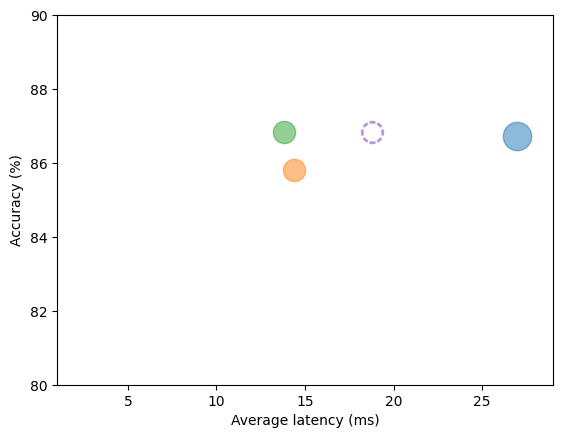

In [52]:
plot_metrics(perf_metrics, optim_type)

In [53]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [54]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)

optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Average latency (ms) - 13.57 +\- 2.78
Accuracy on test set - 0.876


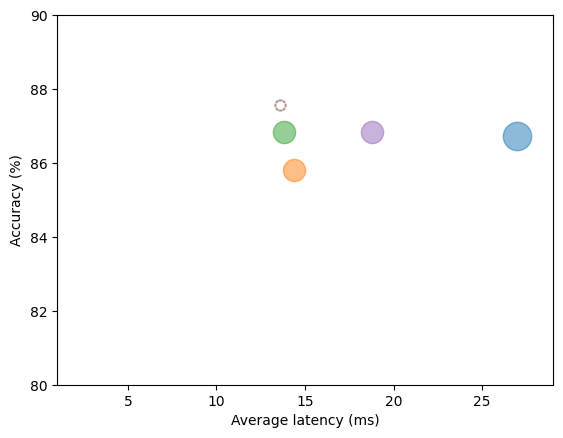

In [55]:
plot_metrics(perf_metrics, optim_type)

## Making Models Sparser with Weight Pruning

There are two techniques:

- Magnitude Pruning: it's the traditional approach
- Movement Pruning: innovative approach proposed by the huggingface team.
